# Time evolution for single spins
-----------------------------------------------------------

## To accompany "Simulating spins dynamics with quantum computers"

#### J. L. Lancaster and D. B. Allen
#### High Point University

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from qiskit import *
%matplotlib inline

In this notebook, we explore the simulation of time evolution in single spin systems. For a quantum state $\left|\psi\right\rangle$, time evolution is governed by the Schrödinger equation,

$$i\hbar \frac{d}{dt}\left|\psi\right\rangle = \hat{H}\left|\psi\right\rangle.$$

For now, we'll assume a time-independent Hamiltonian. In particular, the relevant Hamiltonian for a spin in a constant magnetic field ${\bf B}$ is

$$\hat{H} = -\mu {\bf B}\cdot\hat{\bf S},$$

where $\lambda$ is some constant proportional to the magnetic moment of the spin and $\hat{\bf S} = \hat{S}^{x}\hat{\bf x} +  \hat{S}^{y}\hat{\bf y} + \hat{\bf z} \hat{S}^{z}\hat{\bf z}$. 

As an example, let's suppose $\left|\psi(0)\right\rangle = \left|+\right\rangle$ and ${\bf B} = B_{0}\hat{y}$ for some constant $B_{0}$. For this case, the Hamiltonian simplifies to

$$\hat{H} \rightarrow -\frac{\mu B_{0}\hbar}{2}\sigma^{y} \;\;\dot{=}\;\; -\hbar\omega\left(\begin{array}{cc} 0 & -i\\ i & 0\end{array}\right),$$

where $\omega \equiv \mu B_{0}$. The fundamental problem in quantum dynamics is to predict the probabilities of measurement outcomes or expectation values at some time $t$ given a Hamiltonian $\hat{H}$ and an initial state for the system, $\left|\psi(0)\right\rangle$. We first consider this simple example for which it is straightforward to solve the Schrödinger equation exactly. A formal integration gives

$$\left|\psi(t)\right\rangle = e^{-i\hat{H}t/\hbar}\left|\psi(0)\right\rangle$$,

where 

$$e^{-i\hat{H}t/\hbar} = e^{i\frac{\omega t}{2}\sigma^{y}}.$$

We can compute the exponential of a matrix by using the Taylor expansion of the exponential function as a definition.

$$e^{i\frac{\omega t}{2}\sigma^{y}} \equiv \hat{I} + i\frac{\omega t}{2}\sigma^{y} + \frac{\left(i\frac{\omega t}{2}\sigma^{y}\right)^{2}}{2!} + \frac{\left(i\frac{\omega t}{2}\sigma^{y}\right)^{3}}{3!} + \frac{\left(i\frac{\omega t}{2}\sigma^{y}\right)^{4}}{4!} + \cdots.$$

Using $(\sigma^{y})^{2} = \hat{I}$ and $i^{2} = -1$, one may group even and odd terms

$$e^{i\frac{\omega t}{2}\sigma^{y}} = \hat{I}\left[1 - \frac{(\omega t/2)^{2}}{2!} + \frac{(\omega t/2)^{4}}{4!} + \cdots\right] + i\sigma^{y}\left[\omega t - \frac{(\omega t/2)^{3}}{3!} + \frac{(\omega t/2)^{5}}{5!} + \cdots\right].$$

The series in brackets are cosine and sine Taylor expansions, respectively. Writing out $\hat{I}$ and $\sigma^{y}$ as explicit matrices, we get

$$e^{i\omega t/2\sigma^{y}} = \hat{I}\cos(\omega t/2) + i\sigma^{y}\sin(\omega t/2) \;\;\dot{=}\;\; \left(\begin{array}{cc} \cos(\omega t/2) & \sin(\omega t/2)\\ -\sin(\omega t/2) & \cos(\omega t/2)\end{array}\right)$$

Now recall the general $\hat{U}(\theta,\phi,\lambda)$ gate 

$$\hat{U}(\theta,\phi,\lambda) \;\;\dot{=} \left(\begin{array}{cc} \cos\frac{\theta}{2} & -e^{i\lambda}\sin\frac{\theta}{2} \\ e^{i\phi}\sin\frac{\theta}{2} & e^{i(\lambda + \phi)}\cos\frac{\theta}{2}\end{array}\right)$$

Then the time evolution is equivalent to the following $\hat{U}$ gate:

$$e^{-i\hat{H}t/\hbar} = \hat{U}(\omega t,\pi,\pi),$$

or $\left|\psi(t)\right\rangle = \hat{U}(\omega t,\pi,\pi)\left|+\right\rangle$. Exponentiating the Hamiltonian explicitly is rarely the most efficient way to solve for time dynamics analytically. See one of the [many](https://www.springer.com/gp/book/9780306447907) [excellent](https://www.pearson.com/us/higher-education/program/Mc-Intyre-Quantum-Mechanics/PGM64990.html) [textbooks](https://www.cambridge.org/highereducation/books/introduction-to-quantum-mechanics/990799CA07A83FC5312402AF6860311E#overview) on QM (or just Section IIA in [this paper](https://linus.highpoint.edu/~jlancaster/papers/su3.pdf) paper) for the standard approach. But this approach does lend itself to an efficient quantum circuit design for calculating spin dynamics.

Lastly, we note that in the manuscript $\hat{H} = \mu\hat{S}^{x}$, and it is shown that the time evolution operator becomes

$$|\psi(t)\rangle = \hat{U}\left(\omega t, \frac{\pi}{2},-\frac{\pi}{2}\right)|\psi(0)\rangle$$

This is the case we will consider below.

The basic features of the circuit will be:

1. Generate the initial quantum state $\left|\psi(0)\right\rangle$ through an appropriate unitary transformation of the default initialization $\left|+\right\rangle$.
2. Perform time evolution by applying the gate(s) corresponding to $e^{-i\hat{H}t/\hbar}$.
3. Measure desired observables by appropriate rotation followed by measurement in computational basis.

For our first example, we take $\left|\psi(0)\right\rangle = \left|+\right\rangle$, so no rotation is required before performing step 2. In this first example, let us compute the expectation values $\left\langle \hat{S}^{x}\right\rangle$, $\left\langle \hat{S}^{y}\right\rangle$, $\left\langle \hat{S}^{z}\right\rangle$. To be economical, we can actually embed three copies of the single-spin circuit which only differ in the final gates which select the appropriate spin component for measurement. 

In order to measure the system at a range of time values (say $0\leq \omega t\leq 2\pi$), we can define $\tau = \omega t$ as a parameter.

In [25]:
from qiskit.circuit import Parameter
tau = Parameter('τ')
Nt = 75
qr = QuantumRegister(3,'q')
cr = ClassicalRegister(3,'c')

timecirc = QuantumCircuit(qr,cr) 

#no initial unitary transformation since |ψ(0)> = |+>

timecirc.u(tau,np.pi/2,-np.pi/2,qr) #apply exp(-iHt/ħ)
timecirc.barrier(qr)
timecirc.ry(-np.pi/2,0) #rotation to measure <Sx>

timecirc.rz(-np.pi/2,1) 
timecirc.ry(-np.pi/2,1) #rotation to measure <Sy>
timecirc.barrier(qr)
#no rotation needed to measure <Sz>

timecirc.measure(qr,cr)
timecirc.draw()

┌───────────────┐ ░ ┌──────────┐             ░ ┌─┐      
q_0: ┤ U(τ,π/2,-π/2) ├─░─┤ Ry(-π/2) ├─────────────░─┤M├──────
     ├───────────────┤ ░ ├──────────┤┌──────────┐ ░ └╥┘┌─┐   
q_1: ┤ U(τ,π/2,-π/2) ├─░─┤ Rz(-π/2) ├┤ Ry(-π/2) ├─░──╫─┤M├───
     ├───────────────┤ ░ └──────────┘└──────────┘ ░  ║ └╥┘┌─┐
q_2: ┤ U(τ,π/2,-π/2) ├─░──────────────────────────░──╫──╫─┤M├
     └───────────────┘ ░                          ░  ║  ║ └╥┘
c: 3/════════════════════════════════════════════════╩══╩══╩═
                                                     0  1  2

Next, we define the range for $\tau$ and run on the simulator for some number of shots.

In [26]:
tau_range = np.linspace(0, 2*np.pi, Nt)
Nshots = 8192

job = execute(timecirc,
              backend=BasicAer.get_backend('qasm_simulator'),shots=Nshots,
              parameter_binds=[{tau: t_val} for t_val in tau_range])

simcounts = job.result().get_counts()

Now we must pay the price for lumping three separate single-spin circuits onto a single three-spin circuit. Recall that the measurements will consist of which (total) state was counted, which specifies the state of all three spins in one three-character output. For instance, ```'000'``` refers to all three spin components being measured as up, while ```'001'``` refers to the $x$ and $y$ components being measured $+\frac{\hbar}{2}$, while the $z$ component was measured as $-\frac{\hbar}{2}$. At each time step we are interested in the overall counts for each component indepedently from the states of the others. Later, we will allow interactions between individual spins so that the entire configuration becomes important. But for now, we need to tally the +/- counts for each component while ignoring the states of the others.

For example, to obtain $\left\langle \hat{S}^{x}\right\rangle$, we need to compute

$$\left\langle \hat{S}^{x} \right\rangle = \frac{(\mbox{no. of 0 measurements})\times \frac{\hbar}{2} + (\mbox{no. of 1 measurements})\times \left(-\frac{\hbar}{2}\right)}{N_{shots}}$$ 

The number of '0' measurements refers only to the first spin, so we need to add contributions from ```'000'```, ```'001'```, ```'010'```, and ```'011'```. The remaining four states have a '1' in the first slot, so the sum of these represents the total number of shots for which this spin projection came out as $-\frac{\hbar}{2}$. Thus if we label the number of ```000``` measurements as $\texttt{c000}$ and similarly for the other seven states,

$$\left\langle \hat{S}^{x}\right\rangle = \frac{\hbar}{2}\frac{\texttt{c000} + \texttt{c001} + \texttt{c010}+ \texttt{c011}- \texttt{c100}- \texttt{c101}- \texttt{c110}- \texttt{c111}}{N_{shots}}.$$

Similar reasoning applies to the other components. I should emphasize that you don't <i>have</i> to do it this way. You could just as easily create three single-qubit circuits in which each circuit returned simple counts for a single component of spin. The tradeoff is that you would have to send three separate circuits to the quantum hardware.

In [27]:
c000 = np.array(list(map(lambda c: c.get('000', 0), simcounts)))
c001 = np.array(list(map(lambda c: c.get('001', 0), simcounts)))
c010 = np.array(list(map(lambda c: c.get('010', 0), simcounts)))
c011 = np.array(list(map(lambda c: c.get('011', 0), simcounts)))
c100 = np.array(list(map(lambda c: c.get('100', 0), simcounts)))
c101 = np.array(list(map(lambda c: c.get('101', 0), simcounts)))
c110 = np.array(list(map(lambda c: c.get('110', 0), simcounts)))
c111 = np.array(list(map(lambda c: c.get('111', 0), simcounts)))

Sz = 0.5*(c000+c001+c010+c011-c100-c101-c110-c111)/Nshots
Sy = 0.5*(c000+c001+c100+c101-c010-c011-c110-c111)/Nshots
Sx = 0.5*(c000+c010+c100+c110-c001-c011-c101-c111)/Nshots

We can now plot the spin expectation values as functions of $\theta$. In this simple case, it's useful to verify that this simulated circuit is actually simulating what we <i>think</i> it is. Since the time-dependent state can be computed exactly, it's straightforward to compute the time-dependent expectation values analytically (see derivation above Eq. (13) in [this](https://linus.highpoint.edu/~jlancaster/papers/su3.pdf) paper or any QM textbook),

$$\left\langle \hat{S}^{y}\right\rangle = \frac{\hbar}{2}\sin(\omega t),$$
$$\left\langle \hat{S}^{z}\right\rangle = \frac{\hbar}{2}\cos(\omega t),$$

while $\left\langle \hat{S}^{x}\right\rangle = 0$. So we can plot the simulator results alongside theoretical predictions:

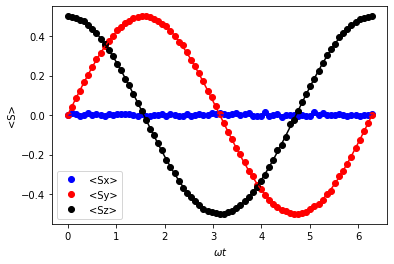

In [28]:
plt.plot(tau_range,Sx,'bo',label='<Sx>')
plt.plot(tau_range,Sy,'ro',label='<Sy>')
plt.plot(tau_range,Sz,'ko',label='<Sz>')
plt.plot(tau_range,0*np.zeros(Nt),'b-')
plt.plot(tau_range,0.5*np.sin(tau_range),'r-')
plt.plot(tau_range,0.5*np.cos(tau_range),'k-')
plt.xlabel('$\omega t$')
plt.ylabel('<S>')
plt.legend()
plt.show()

Next, we can send this to actual quantum hardware.

<b>NOTE:</b> You will need an IBM Quantum account for this part so that you can paste your API into the field below. You can also skip cells involving the actual devices to perform simulations in the remainder of this notebook.

In [11]:
IBMQ.load_account('paste-your-API-here')

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [12]:
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

In [ ]:
qcomp = provider.get_backend('ibmq_lima')

job = execute(timecirc, backend=qcomp,shots=Nshots,parameter_binds=[{tau: t_val} for t_val in tau_range])
from qiskit.tools.monitor import job_monitor
job_monitor(job)
qcounts = job.result().get_counts()

It's never a bad idea to print the job ID so it can be accessed later. What follows is the same post-processing we used for the simulator and a similar plot.

In [ ]:
job.job_id()

In [34]:
#Data stored in job '613d0d348228224fe7e2122a' (ibmq_bogota)
cq000 = np.array(list(map(lambda c: c.get('000', 0), qcounts)))
cq001 = np.array(list(map(lambda c: c.get('001', 0), qcounts)))
cq010 = np.array(list(map(lambda c: c.get('010', 0), qcounts)))
cq011 = np.array(list(map(lambda c: c.get('011', 0), qcounts)))
cq100 = np.array(list(map(lambda c: c.get('100', 0), qcounts)))
cq101 = np.array(list(map(lambda c: c.get('101', 0), qcounts)))
cq110 = np.array(list(map(lambda c: c.get('110', 0), qcounts)))
cq111 = np.array(list(map(lambda c: c.get('111', 0), qcounts)))

Szq = 0.5*(cq000+cq001+cq010+cq011-cq100-cq101-cq110-cq111)/Nshots
Syq = 0.5*(cq000+cq001+cq100+cq101-cq010-cq011-cq110-cq111)/Nshots
Sxq = 0.5*(cq000+cq010+cq100+cq110-cq001-cq011-cq101-cq111)/Nshots

In [ ]:
plt.plot(tau_range,Sxq,'bo',label='<Sx>')
plt.plot(tau_range,Syq,'ro',label='<Sy>')
plt.plot(tau_range,Szq,'ko',label='<Sz>')
plt.plot(tau_range,0*np.zeros(Nt),'b-')
plt.plot(tau_range,0.5*np.sin(tau_range),'r-')
plt.plot(tau_range,0.5*np.cos(tau_range),'k-')
plt.xlabel('$\omega t$')
plt.ylabel('<S>')
plt.legend()
plt.show()

### Time evolution operator for arbitrary magnetic field


It's possible to compute the general case ${\bf B} = B_{0}\hat{\bf n}$, but implementation is somewhat tricky due to a limited number of built-in functions to act on ```Parameter``` objects. Instead of tackling that, let's just look closely at a particular example of a magnetic field with more than one component:

$${\bf B} = \frac{B_{0}}{\sqrt{2}}\hat{\bf x} + \frac{B_{0}}{\sqrt{2}}\hat{\bf y}$$

This corresponds to $\theta = \frac{\pi}{2}$, $\phi = \frac{\pi}{4}$, so

$$\exp\left[-i\hat{H}t/\hbar\right] = \hat{U}\left(\omega t, \frac{3\pi}{4}, -\frac{3\pi}{4}\right)$$

Analytically, we can write out the expected spin components as 

$$\left\langle \hat{S}^{x} -\right\rangle = \frac{\hbar}{2}\cos\frac{3\pi}{4}\sin(\omega t)$$
$$\left\langle \hat{S}^{y} \right\rangle = \frac{\hbar}{2}\sin\frac{3\pi}{4}\sin(\omega t)$$
$$\left\langle \hat{S}^{z} \right\rangle = \frac{\hbar}{2}\cos(\omega t)$$

In [16]:
tau = Parameter('τ')
Nt = 75
qr = QuantumRegister(3)
cr = ClassicalRegister(3)

timecirc = QuantumCircuit(qr,cr) 
θ = np.pi/2
ϕ = np.pi/4

timecirc.u(tau,np.pi/2+ϕ,-np.pi/2-ϕ,qr)
timecirc.barrier(qr)
timecirc.ry(-np.pi/2,2) #rotation to measure <Sx>

timecirc.rz(-np.pi/2,1) 
timecirc.ry(-np.pi/2,1) #rotation to measure <Sy>
timecirc.barrier(qr)
#no rotation needed to measure <Sz>

timecirc.measure(qr,cr)
timecirc.draw()

┌─────────────────┐ ░                          ░ ┌─┐      
q77_0: ┤ U(τ,3π/4,-3π/4) ├─░──────────────────────────░─┤M├──────
       ├─────────────────┤ ░ ┌──────────┐┌──────────┐ ░ └╥┘┌─┐   
q77_1: ┤ U(τ,3π/4,-3π/4) ├─░─┤ Rz(-π/2) ├┤ Ry(-π/2) ├─░──╫─┤M├───
       ├─────────────────┤ ░ ├──────────┤└──────────┘ ░  ║ └╥┘┌─┐
q77_2: ┤ U(τ,3π/4,-3π/4) ├─░─┤ Ry(-π/2) ├─────────────░──╫──╫─┤M├
       └─────────────────┘ ░ └──────────┘             ░  ║  ║ └╥┘
 c1: 3/══════════════════════════════════════════════════╩══╩══╩═
                                                         0  1  2

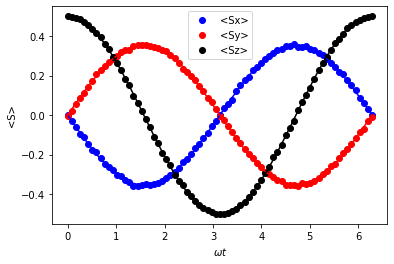

In [17]:
tau_range = np.linspace(0, 2*np.pi, Nt)
Nshots = 8192

job = execute(timecirc,
              backend=BasicAer.get_backend('qasm_simulator'),shots=Nshots,
              parameter_binds=[{tau: t_val} for t_val in tau_range])

simcounts = job.result().get_counts()

c000 = np.array(list(map(lambda c: c.get('000', 0), simcounts)))
c001 = np.array(list(map(lambda c: c.get('001', 0), simcounts)))
c010 = np.array(list(map(lambda c: c.get('010', 0), simcounts)))
c011 = np.array(list(map(lambda c: c.get('011', 0), simcounts)))
c100 = np.array(list(map(lambda c: c.get('100', 0), simcounts)))
c101 = np.array(list(map(lambda c: c.get('101', 0), simcounts)))
c110 = np.array(list(map(lambda c: c.get('110', 0), simcounts)))
c111 = np.array(list(map(lambda c: c.get('111', 0), simcounts)))

Sx = 0.5*(c000+c001+c010+c011-c100-c101-c110-c111)/Nshots
Sy = 0.5*(c000+c001+c100+c101-c010-c011-c110-c111)/Nshots
Sz = 0.5*(c000+c010+c100+c110-c001-c011-c101-c111)/Nshots

plt.plot(tau_range,Sx,'bo',label='<Sx>')
plt.plot(tau_range,Sy,'ro',label='<Sy>')
plt.plot(tau_range,Sz,'ko',label='<Sz>')
plt.plot(tau_range,0.5*np.cos(3*np.pi/4)*np.sin(tau_range),'b-')
plt.plot(tau_range,0.5*np.sin(3*np.pi/4)*np.sin(tau_range),'r-')
plt.plot(tau_range,0.5*np.cos(tau_range),'k-')
plt.xlabel('$\omega t$')
plt.ylabel('<S>')
plt.legend()
plt.show()

We can also run the same circuit on actual hardware.

In [ ]:
tau_range = np.linspace(0, 2*np.pi, Nt)
Nshots = 8192

qcomp = #provider.get_backend('ibm_lagos')

job = execute(timecirc, backend=qcomp,shots=Nshots,parameter_binds=[{tau: t_val} for t_val in tau_range])
from qiskit.tools.monitor import job_monitor
job_monitor(job)
qcounts = job.result().get_counts()

c000 = np.array(list(map(lambda c: c.get('000', 0), qcounts)))
c001 = np.array(list(map(lambda c: c.get('001', 0), qcounts)))
c010 = np.array(list(map(lambda c: c.get('010', 0), qcounts)))
c011 = np.array(list(map(lambda c: c.get('011', 0), qcounts)))
c100 = np.array(list(map(lambda c: c.get('100', 0), qcounts)))
c101 = np.array(list(map(lambda c: c.get('101', 0), qcounts)))
c110 = np.array(list(map(lambda c: c.get('110', 0), qcounts)))
c111 = np.array(list(map(lambda c: c.get('111', 0), qcounts)))

Sxq = 0.5*(c000+c001+c010+c011-c100-c101-c110-c111)/Nshots
Syq = 0.5*(c000+c001+c100+c101-c010-c011-c110-c111)/Nshots
Szq = 0.5*(c000+c010+c100+c110-c001-c011-c101-c111)/Nshots

plt.plot(tau_range,Sxq,'bo',label='<Sx>')
plt.plot(tau_range,Syq,'ro',label='<Sy>')
plt.plot(tau_range,Szq,'ko',label='<Sz>')
plt.plot(tau_range,0.5*np.cos(3*np.pi/4)*np.sin(tau_range),'b-')
plt.plot(tau_range,0.5*np.sin(3*np.pi/4)*np.sin(tau_range),'r-')
plt.plot(tau_range,0.5*np.cos(tau_range),'k-')
plt.xlabel('$\omega t$')
plt.ylabel('<S>')
plt.legend()
plt.show()

### Introduction to Trotter steps

For short time steps, we <i>can</i> approximate the full operator by a sequence of noncommuting operators. Taking the full time evolution operator to be of the form $\hat{U} = \exp\left[it(\hat{A}+\hat{B})\right]$ for $\left[\hat{A},\hat{B}\right] \neq 0$. It is possible to show that

$$\exp\left[it\left(\hat{A}+\hat{B}\right)\right] = \lim_{n\rightarrow\infty}\left(\exp\left[i\frac{t}{n}\hat{A}\right]\left[i\frac{t}{n}\hat{B}\right]\right)^{n}$$

That is, we <i>should</i> be able to get increasingly accurate results by slicing up the time step into many substeps. The above expression is known as the <b>Lie-Trotter formula</b>, and the main idea is to compute (approximately) the time evolution of the quantum state at time $t$ by taking $n$ small steps of size $\frac{t}{n}$ using the product of simpler operator exponentials. For $n$ sufficiently large, the approximate result should converge to the exact result. This process is sometimes referred to as <b>Trotterization</b>.

Before diving in, it's worth asking <i>why</i> one would do this when the exact result is much simpler. The interactions of a single spin with an external magnetic field are special in that it is possible to obtain the exact time evolution operator. For multiple spins, the types of possible interactions <i>between</i> spins result in significantly more complicated Hamiltonians for which this exact analysis is not generally possible. But by decomposing (approximately) the exponential of a fairly complicated Hamiltonian into a series of simple Trotterized factors, it becomes possible to simulate much more interesting dynamics. Indeed, the anticipated value of future quantum devices is that such simulations will be much more efficient than state-of-the-art computations on classical devices.

Below is an example of the Trotterization scheme where the number of Trotter steps is set to ```ntrot```. 

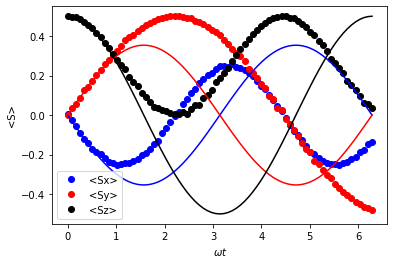

In [40]:
tau = Parameter('τ')
Nt = 75

tau_range = np.linspace(0, 2*np.pi, Nt)
Nshots = 8192

qr = QuantumRegister(3)
cr = ClassicalRegister(3)

timecirc0 = QuantumCircuit(qr,cr) 
θ = np.pi/2
ϕ = np.pi/4

#vary this:
ntrot = 2

for i in range(0,ntrot):
    timecirc0.u(tau/(np.sqrt(2)*ntrot),np.pi/2,-np.pi/2,qr)
    timecirc0.u(tau/(np.sqrt(2)*ntrot),np.pi,-np.pi,qr)
    
timecirc0.barrier(qr)
timecirc0.ry(-np.pi/2,2) #rotation to measure <Sx>

timecirc0.rz(-np.pi/2,1) 
timecirc0.ry(-np.pi/2,1) #rotation to measure <Sy>
timecirc0.barrier(qr)
#no rotation needed to measure <Sz>

timecirc0.measure(qr,cr)
timecirc0.draw()


job = execute(timecirc0, backend=BasicAer.get_backend('qasm_simulator'),shots=Nshots,
              parameter_binds=[{tau: t_val} for t_val in tau_range])

counts = job.result().get_counts()

c000 = np.array(list(map(lambda c: c.get('000', 0), counts)))
c001 = np.array(list(map(lambda c: c.get('001', 0), counts)))
c010 = np.array(list(map(lambda c: c.get('010', 0), counts)))
c011 = np.array(list(map(lambda c: c.get('011', 0), counts)))
c100 = np.array(list(map(lambda c: c.get('100', 0), counts)))
c101 = np.array(list(map(lambda c: c.get('101', 0), counts)))
c110 = np.array(list(map(lambda c: c.get('110', 0), counts)))
c111 = np.array(list(map(lambda c: c.get('111', 0), counts)))

Sx = 0.5*(c000+c001+c010+c011-c100-c101-c110-c111)/Nshots
Sy = 0.5*(c000+c001+c100+c101-c010-c011-c110-c111)/Nshots
Sz = 0.5*(c000+c010+c100+c110-c001-c011-c101-c111)/Nshots

plt.plot(tau_range,Sx,'bo',label='<Sx>')
plt.plot(tau_range,Sy,'ro',label='<Sy>')
plt.plot(tau_range,Sz,'ko',label='<Sz>')
plt.plot(tau_range,0.5*np.cos(3*np.pi/4)*np.sin(tau_range),'b-')
plt.plot(tau_range,0.5*np.sin(3*np.pi/4)*np.sin(tau_range),'r-')
plt.plot(tau_range,0.5*np.cos(tau_range),'k-')
plt.xlabel('$\omega t$')
plt.ylabel('<S>')
plt.legend()
plt.show()

By copying and pasting, the approximate "Trotterized" circuit can also be sent to actual hardware using the appropriate syntax changes.